In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Week 4: From MLPs to Convolutional Neural Networks**
### José Manuel López, Alex Martín, Marcos V. Conde

#### <ins>Understanding Layer Manipulation</ins>
1. Check existing architectures
2. Set a new model from an existing architecture
3. Apply model to a small dataset

#### <ins>Deal with dataset loading</ins>
4. Introduce and evaluate Data Augmentation Impact

#### <ins>Hyperparametrs optimization</ins>
4. Introduce and evaluate the usage of dropout, batch normalization, ...
5. Apply random search on model hyperparametes

In [ ]:
from tensorflow.python.util import deprecation
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.python.client import device_lib 
import tensorflow as tf
import warnings
import os
from tensorflow.keras import backend as K

Tensorflow allocates all VRAM without this.
Additionally we want to enable mixed precision aka use TensorCores if our GPU is capable to speedup the computation.

In [ ]:
# Disable Warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# VRAM broke without this
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.config.experimental_run_functions_eagerly(True)

try:
    # print model to see if it's compatible with Mixed Precision
    print(device_lib.list_local_devices()[1].physical_device_desc)
    # Change to TF16 mixed precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
except:
    pass

print(gpus[0])
print(tf.__version__)

device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7
Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.7.0


### Loading Datasets

We are going to define variables related to dataset and load data into generators

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def preprocess_input_manual(x, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.image_data_format()
    assert dim_ordering in {'channels_first', 'channels_last'}

    if dim_ordering == 'channels_first':
        # 'RGB'->'BGR'
        x = x[ ::-1, :, :]
        # Zero-center by mean pixel
        x[ 0, :, :] -= 103.939
        x[ 1, :, :] -= 116.779
        x[ 2, :, :] -= 123.68
    else:
        # 'RGB'->'BGR'
        x = x[:, :, ::-1]
        # Zero-center by mean pixel
        x[:, :, 0] -= 103.939
        x[:, :, 1] -= 116.779
        x[:, :, 2] -= 123.68
    return x

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
RANDOM_SEED = 42
validation_samples = 2288
CLASSES = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding']
def get_dataset(path, batch_size=32):
    print("Loading: {}".format(path))
    datagen = ImageDataGenerator(featurewise_center=False,
              samplewise_center=False,
              featurewise_std_normalization=False,
              samplewise_std_normalization=False,
              preprocessing_function=preprocess_input_manual,
              rotation_range=0.,
              width_shift_range=0.,
              height_shift_range=0.,
              shear_range=0.,
              zoom_range=0.,
              channel_shift_range=0.,
              fill_mode='nearest',
              cval=0.,
              horizontal_flip=False,
              vertical_flip=False,
              rescale=None)

    train_loader = datagen.flow_from_directory(
                path+'/train',  
                target_size=(IMG_SIZE, IMG_SIZE), 
                batch_size=BATCH_SIZE,
                classes = CLASSES,
                class_mode='categorical') 

    test_loader = datagen.flow_from_directory(
            path+'/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            classes = CLASSES,
            class_mode='categorical')
    

    examples = enumerate(test_loader)
    batch_idx, (example_data, example_targets) = next(examples)
    print("Data Shape: {}".format(example_data.shape))
    print("---"*30)

    return train_loader, test_loader

In [ ]:

DATA_DIR = "/content/drive/MyDrive/MIT_small_train_1/MIT_small_train_{}"

# Dataset 1
train_loader_1, test_loader_1 = get_dataset(DATA_DIR.format(1))
"""# Dataset 2
train_loader_2, test_loader_2 = get_dataset(DATA_DIR.format(2))
# Dataset 3
train_loader_3, test_loader_3 = get_dataset(DATA_DIR.format(3))
# Dataset 4
train_loader_4, test_loader_4 = get_dataset(DATA_DIR.format(4))"""

Loading: /content/drive/MyDrive/MIT_small_train_1/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (32, 224, 224, 3)
------------------------------------------------------------------------------------------


'# Dataset 2\ntrain_loader_2, test_loader_2 = get_dataset(DATA_DIR.format(2))\n# Dataset 3\ntrain_loader_3, test_loader_3 = get_dataset(DATA_DIR.format(3))\n# Dataset 4\ntrain_loader_4, test_loader_4 = get_dataset(DATA_DIR.format(4))'

## Check existing architectures: ResNet50
We are going to try ResNet50 pretrained on ImageNet and evaluate the performance of the model.

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt


N: 26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: [('n02843684', 'birdhouse', 0.265), ('n03930313', 'picket_fence', 0.1497), ('n04005630', 'prison', 0.0555)]
Real: inside_city


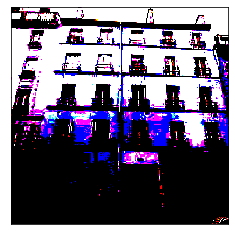

In [ ]:
examples = enumerate(train_loader_1)
batch_idx, (example_data, example_targets) = next(examples)
n = np.random.randint(low = 0, high = len(example_data)+1, size=1)[0]

print("N: {}".format(n))

x = preprocess_input_manual(example_data)
model = ResNet50(weights='imagenet')
preds = model.predict(x)

examples = enumerate(train_loader_1)
batch_idx, (example_data, example_targets) = next(examples)

print('Predicted:', decode_predictions(preds, top=3)[n])
print('Real:', CLASSES[np.argmax(example_targets[n])])

plt.imshow(example_data[n], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

## Fine tuning and existing architecture
Now we are we are going to use ResNet50's skeleton and change the last layer to perform the classification. 

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
def plot_loss_accuracy(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))
    
    fig.suptitle(title, fontsize=16)

    # Plot history: CrossEntropy
    ax1.plot(history.history['loss'], label='CrossEntropy (training data)')
    ax1.plot(history.history['val_loss'], label='CrossEntropy (validation data)')
    ax1.set_title('Loss Function: Cross Entropy')
    ax1.set(xlabel='Epoch', ylabel='Loss Value')
    ax1.legend(loc="upper left")

    # Plot history: Accuracy
    ax2.plot(history.history['accuracy'], label='Accuracy (training data)')
    ax2.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
    ax2.set_title('Accuracy')
    ax2.set(xlabel='Epoch', ylabel='Accuracy Value')
    ax2.legend(loc="upper left")

    plt.show()
    plt.savefig('accuracy_loss.jpg')

In [ ]:
def buil_custom_resnet50(opti ='adadelta',summary=False):
    # ResNet Base Model
    base_model = ResNet50(weights='imagenet')
    x = base_model.layers[-2].output

    # Perform classification
    predictions = Dense(len(CLASSES), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # We don't want to modify imagenet weights
    for layer in base_model.layers:
        layer.trainable = False
            
    # Compile model
    model.compile(optimizer= opti, loss='categorical_crossentropy',metrics=["accuracy"])
    if summary:
      model.summary()
    return model

# Training on first datasets
model = buil_custom_resnet50()


102981632/102967424 [==============================] - 1s 0us/step
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [ ]:
history_1 = model.fit(train_loader_1,steps_per_epoch= int(400 // BATCH_SIZE), epochs=50, validation_data=test_loader_1, validation_steps= int(validation_samples // BATCH_SIZE))
"""
# Dataset 2
model = buil_custom_resnet50(layers=[Dense(1024, activation='relu')])
history_2 = model.fit(train_loader_2,steps_per_epoch=400 // BATCH_SIZE, epochs=5, validation_data=test_loader_2, validation_steps=2288 // BATCH_SIZE)
# Dataset 3
model = buil_custom_resnet50(layers=[Dense(1024, activation='relu')])
history_3 = model.fit(train_loader_3,steps_per_epoch=400 // BATCH_SIZE, epochs=5, validation_data=test_loader_3, validation_steps=2288 // BATCH_SIZE)
# Dataset 4
model = buil_custom_resnet50(layers=[Dense(1024, activation='relu')])
history_4 = model.fit(train_loader_4,steps_per_epoch=400 // BATCH_SIZE, epochs=5, validation_data=test_loader_4, validation_steps=2288 // BATCH_SIZE)
"""

Epoch 1/50
12/12 [==============================] - 32s 3s/step - loss: 2.3794 - accuracy: 0.1413 - val_loss: 2.3886 - val_accuracy: 0.1442
Epoch 2/50
12/12 [==============================] - 29s 3s/step - loss: 2.4102 - accuracy: 0.1304 - val_loss: 2.4123 - val_accuracy: 0.1538
Epoch 3/50
12/12 [==============================] - 26s 2s/step - loss: 2.3856 - accuracy: 0.1458 - val_loss: 2.4167 - val_accuracy: 0.1538
Epoch 4/50
12/12 [==============================] - 21s 2s/step - loss: 2.3923 - accuracy: 0.1467 - val_loss: 2.4199 - val_accuracy: 0.1430
Epoch 5/50
12/12 [==============================] - 19s 2s/step - loss: 2.3841 - accuracy: 0.1467 - val_loss: 2.4268 - val_accuracy: 0.1406
Epoch 6/50
12/12 [==============================] - 18s 2s/step - loss: 2.3801 - accuracy: 0.1467 - val_loss: 2.4050 - val_accuracy: 0.1550
Epoch 7/50
12/12 [==============================] - 20s 2s/step - loss: 2.3448 - accuracy: 0.1467 - val_loss: 2.4048 - val_accuracy: 0.1478
Epoch 8/50
12/12 [==

"\n# Dataset 2\nmodel = buil_custom_resnet50(layers=[Dense(1024, activation='relu')])\nhistory_2 = model.fit(train_loader_2,steps_per_epoch=400 // BATCH_SIZE, epochs=5, validation_data=test_loader_2, validation_steps=2288 // BATCH_SIZE)\n# Dataset 3\nmodel = buil_custom_resnet50(layers=[Dense(1024, activation='relu')])\nhistory_3 = model.fit(train_loader_3,steps_per_epoch=400 // BATCH_SIZE, epochs=5, validation_data=test_loader_3, validation_steps=2288 // BATCH_SIZE)\n# Dataset 4\nmodel = buil_custom_resnet50(layers=[Dense(1024, activation='relu')])\nhistory_4 = model.fit(train_loader_4,steps_per_epoch=400 // BATCH_SIZE, epochs=5, validation_data=test_loader_4, validation_steps=2288 // BATCH_SIZE)\n"

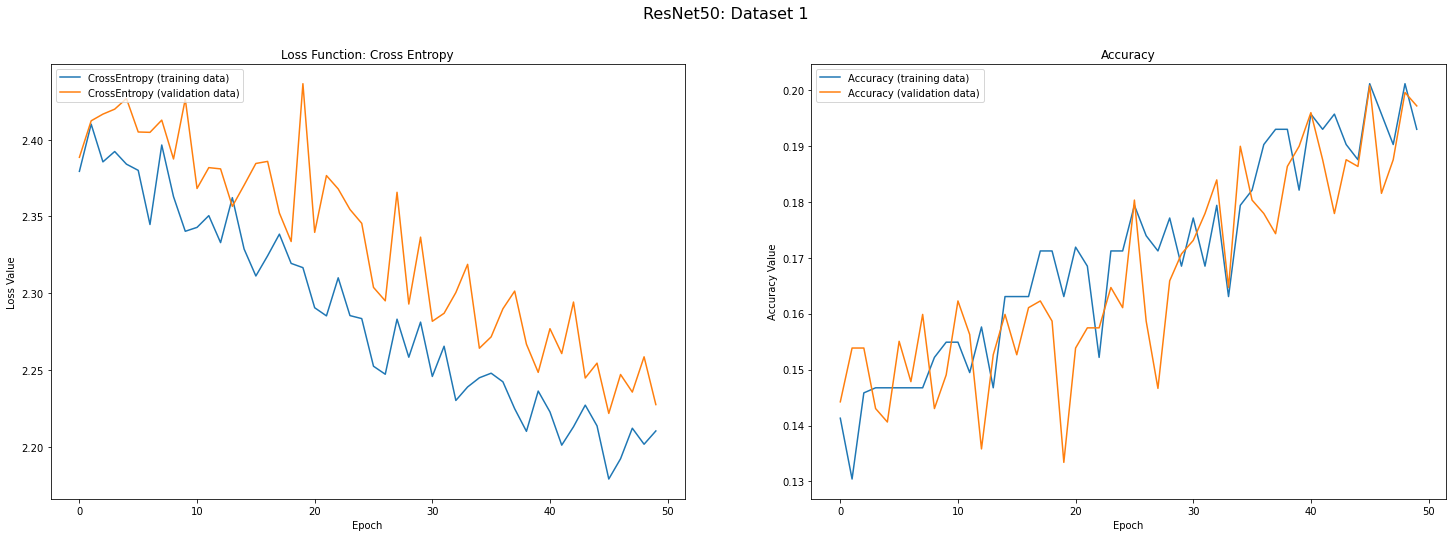

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_loss_accuracy(history_1, 'ResNet50: Dataset 1')


With the example code delivered we obtain the above results by using the weights from ResNet50 after training with Imagenet. Now we will start to search for the optimal values of the hyperparameters to get better results


We will always use the Early stopping to avoid trainings that are not evolving to give better results. 


**Random search**

To perform the training with different batch sizes we have to load the data witht the desired batch size previously. 

Batch sizes that will be used:  [33, 67, 96, 29, 88, 73, 59]
Loading: /content/drive/MyDrive/MIT_small_train_1/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (33, 224, 224, 3)
------------------------------------------------------------------------------------------
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Epoch 1/50
12/12 [==============================] - 149s 13s/step - loss: 5.8142 - accuracy: 0.6515 - val_loss: 1.7581 - val_accuracy: 0.8924
Epoch 2/50
12/12 [==============================] - 27s 2s/step - loss: 3.8560 - accuracy: 0.8556 - val_loss: 1.4152 - val_accuracy: 0.9179
Epoch 3/50
12/12 [==============================] - 27s 2s/step - loss: 0.7082 - accuracy: 0.9591 - val_loss: 6.0783 - val_accuracy: 0.8129
Epoch 4/50
12/12 [==============================] - 27s 2s/step - loss: 2.9395 - accuracy: 0.9074 - val_loss: 3.3473 - val_accuracy: 0.8612
Epoch 5/50
12/12 [=============================

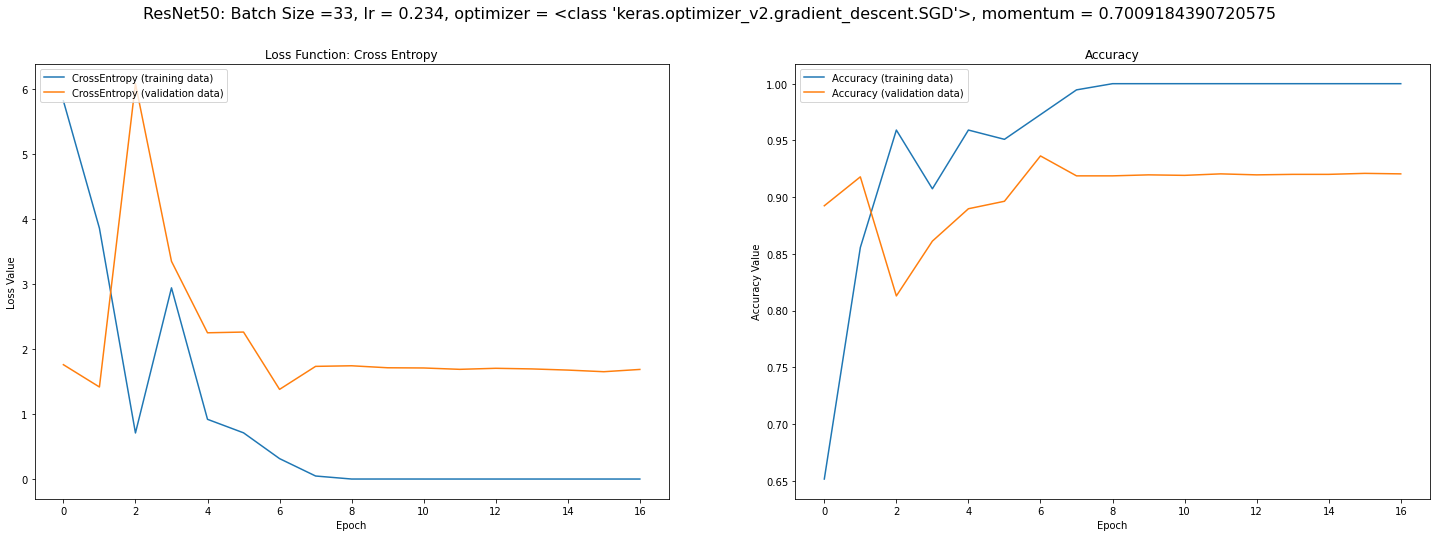

Loading: /content/drive/MyDrive/MIT_small_train_1/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (67, 224, 224, 3)
------------------------------------------------------------------------------------------
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Epoch 1/50
5/5 [==============================] - 29s 7s/step - loss: 3.3154 - accuracy: 0.4505 - val_loss: 0.4703 - val_accuracy: 0.8727
Epoch 2/50
5/5 [==============================] - 28s 7s/step - loss: 0.3668 - accuracy: 0.8979 - val_loss: 0.3089 - val_accuracy: 0.9017
Epoch 3/50
5/5 [==============================] - 23s 5s/step - loss: 0.2065 - accuracy: 0.9399 - val_loss: 0.2603 - val_accuracy: 0.9140
Epoch 4/50
5/5 [==============================] - 29s 7s/step - loss: 0.0916 - accuracy: 0.9730 - val_loss: 0.2412 - val_accuracy: 0.9192
Epoch 5/50
5/5 [==============================] - 23s 5s/step - loss: 0.1060 - accuracy: 0.9790 - val_loss: 0.2385 - v

<Figure size 432x288 with 0 Axes>

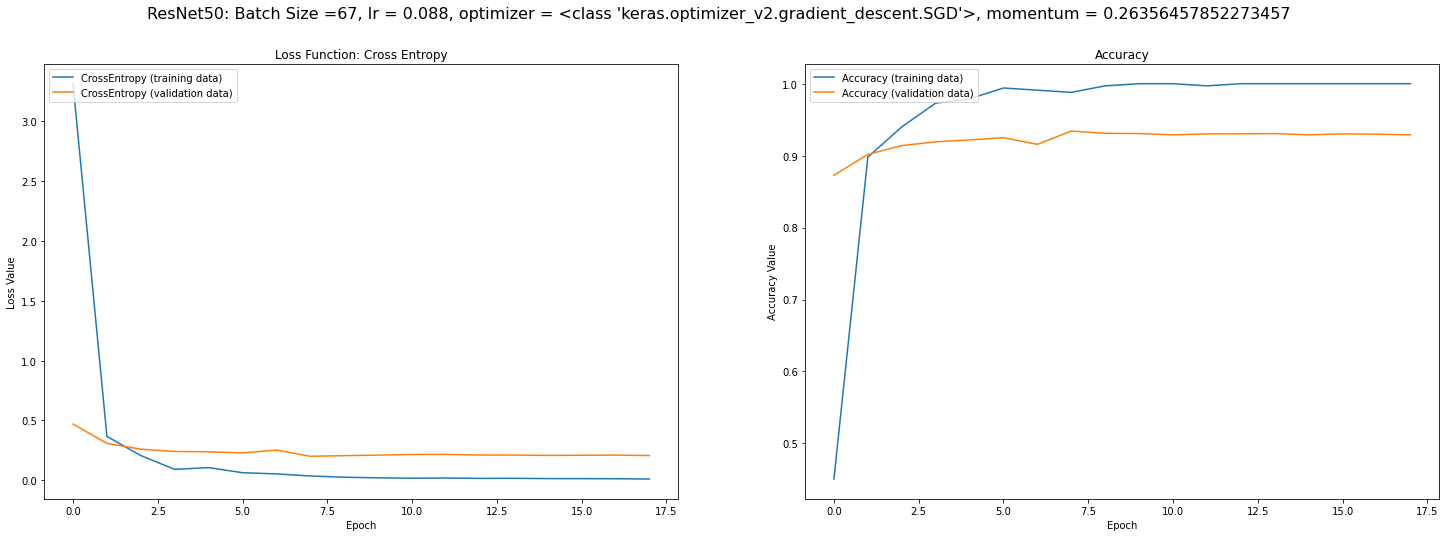

Loading: /content/drive/MyDrive/MIT_small_train_1/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (96, 224, 224, 3)
------------------------------------------------------------------------------------------
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Epoch 1/50
4/4 [==============================] - 31s 9s/step - loss: 209.6151 - accuracy: 0.2171 - val_loss: 456.9783 - val_accuracy: 0.1418
Epoch 2/50
4/4 [==============================] - 22s 6s/step - loss: 229.2303 - accuracy: 0.4901 - val_loss: 30.4762 - val_accuracy: 0.8048
Epoch 3/50
4/4 [==============================] - 23s 7s/step - loss: 15.9619 - accuracy: 0.8932 - val_loss: 14.4082 - val_accuracy: 0.8841
Epoch 4/50
4/4 [==============================] - 22s 6s/step - loss: 6.7710 - accuracy: 0.9474 - val_loss: 15.2565 - val_accuracy: 0.8773
Epoch 5/50
4/4 [==============================] - 28s 8s/step - loss: 7.2005 - accuracy: 0.9408 - val_loss: 

<Figure size 432x288 with 0 Axes>

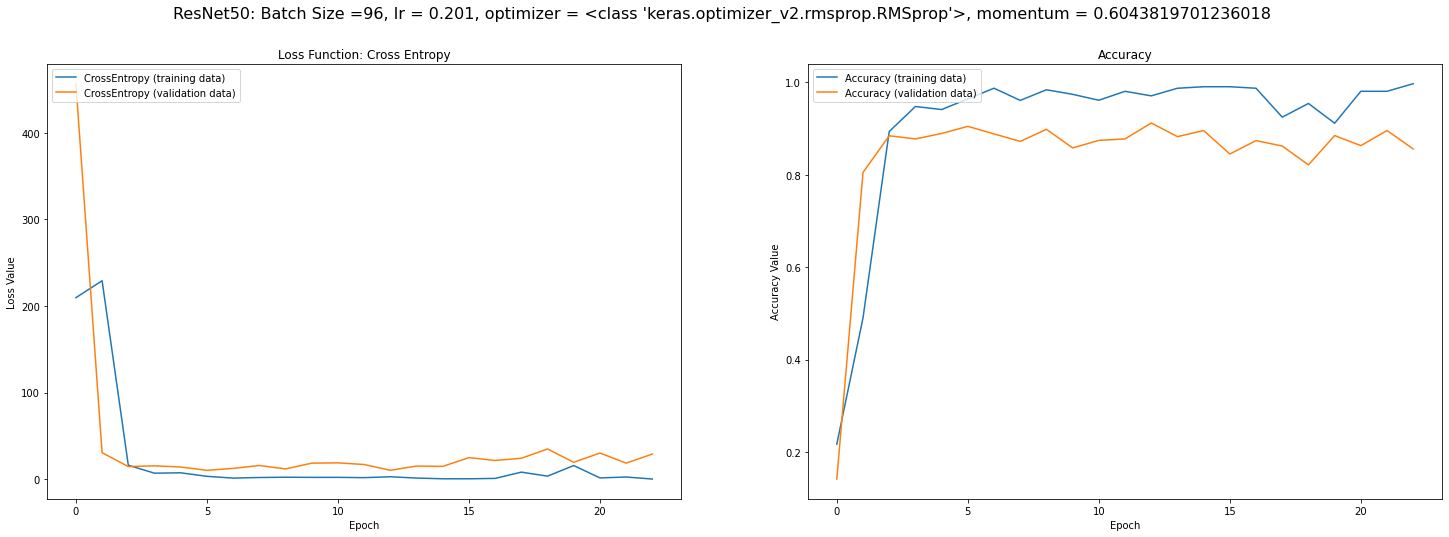

Loading: /content/drive/MyDrive/MIT_small_train_1/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (29, 224, 224, 3)
------------------------------------------------------------------------------------------
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Epoch 1/50
13/13 [==============================] - 32s 3s/step - loss: 1.5268 - accuracy: 0.5930 - val_loss: 0.2653 - val_accuracy: 0.9045
Epoch 2/50
13/13 [==============================] - 28s 2s/step - loss: 0.1866 - accuracy: 0.9461 - val_loss: 0.2277 - val_accuracy: 0.9253
Epoch 3/50
13/13 [==============================] - 30s 2s/step - loss: 0.1466 - accuracy: 0.9629 - val_loss: 0.2239 - val_accuracy: 0.9253
Epoch 4/50
13/13 [==============================] - 30s 2s/step - loss: 0.0903 - accuracy: 0.9811 - val_loss: 0.2658 - val_accuracy: 0.9023
Epoch 5/50
13/13 [==============================] - 30s 2s/step - loss: 0.0802 - accuracy: 0.9811 - val_loss: 

<Figure size 432x288 with 0 Axes>

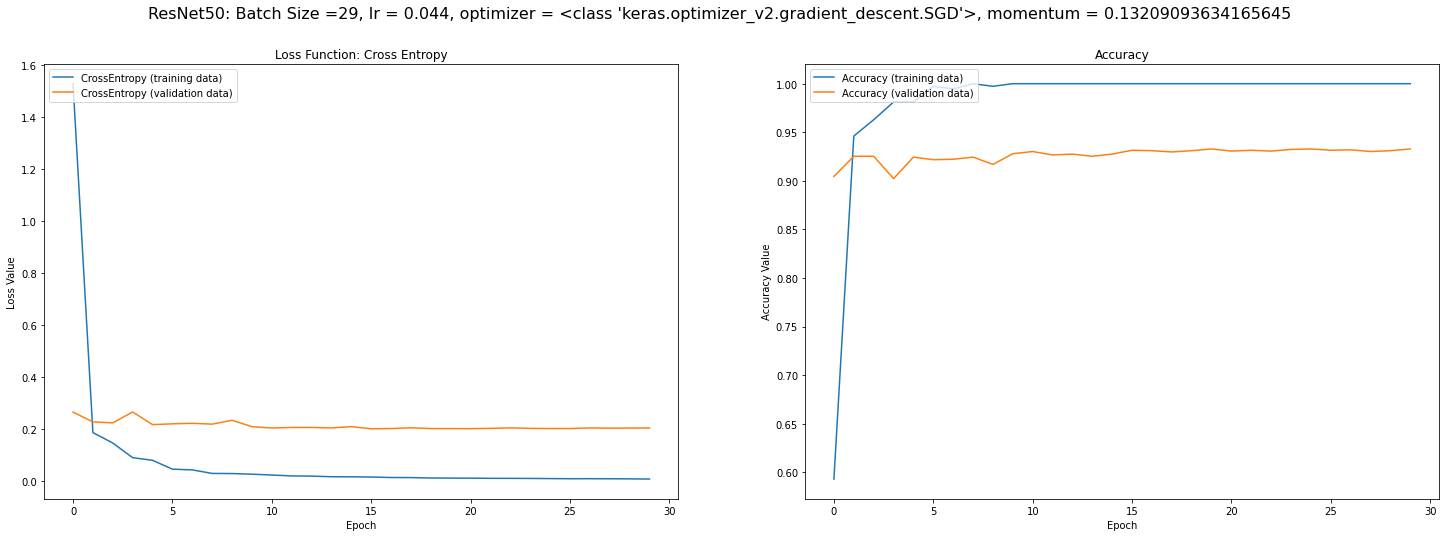

Loading: /content/drive/MyDrive/MIT_small_train_1/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (88, 224, 224, 3)
------------------------------------------------------------------------------------------
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Epoch 1/50
4/4 [==============================] - 26s 7s/step - loss: 97.4712 - accuracy: 0.2564 - val_loss: 87.1550 - val_accuracy: 0.5328
Epoch 2/50
4/4 [==============================] - 22s 7s/step - loss: 71.8642 - accuracy: 0.6410 - val_loss: 27.3486 - val_accuracy: 0.8252
Epoch 3/50
4/4 [==============================] - 28s 8s/step - loss: 12.0492 - accuracy: 0.9295 - val_loss: 15.1318 - val_accuracy: 0.8789
Epoch 4/50
4/4 [==============================] - 22s 7s/step - loss: 6.1853 - accuracy: 0.9487 - val_loss: 8.6927 - val_accuracy: 0.9126
Epoch 5/50
4/4 [==============================] - 23s 7s/step - loss: 2.4197 - accuracy: 0.9801 - val_loss: 13.1

<Figure size 432x288 with 0 Axes>

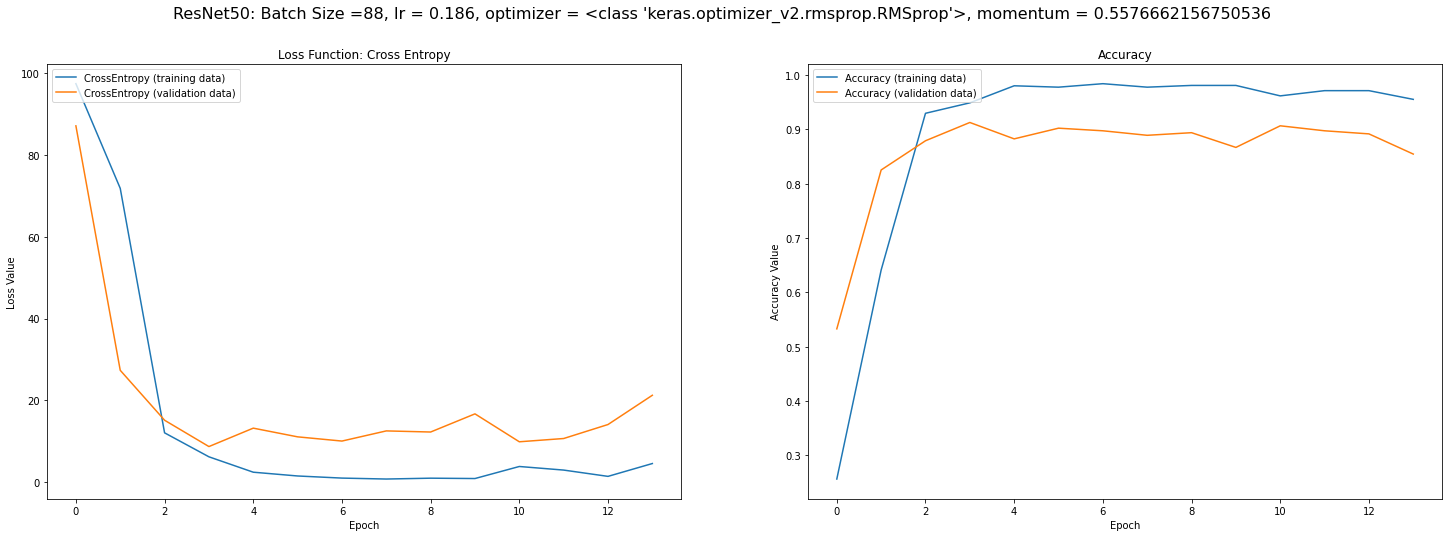

Loading: /content/drive/MyDrive/MIT_small_train_1/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (73, 224, 224, 3)
------------------------------------------------------------------------------------------
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Epoch 1/50
5/5 [==============================] - 31s 7s/step - loss: 57.8910 - accuracy: 0.3890 - val_loss: 38.7757 - val_accuracy: 0.6328
Epoch 2/50
5/5 [==============================] - 29s 7s/step - loss: 15.8910 - accuracy: 0.8226 - val_loss: 5.4974 - val_accuracy: 0.8939
Epoch 3/50
5/5 [==============================] - 28s 7s/step - loss: 2.5893 - accuracy: 0.9297 - val_loss: 7.8948 - val_accuracy: 0.8657
Epoch 4/50
5/5 [==============================] - 23s 5s/step - loss: 2.3749 - accuracy: 0.9419 - val_loss: 6.1554 - val_accuracy: 0.8917
Epoch 5/50
5/5 [==============================] - 29s 7s/step - loss: 1.3897 - accuracy: 0.9589 - val_loss: 4.4386 

<Figure size 432x288 with 0 Axes>

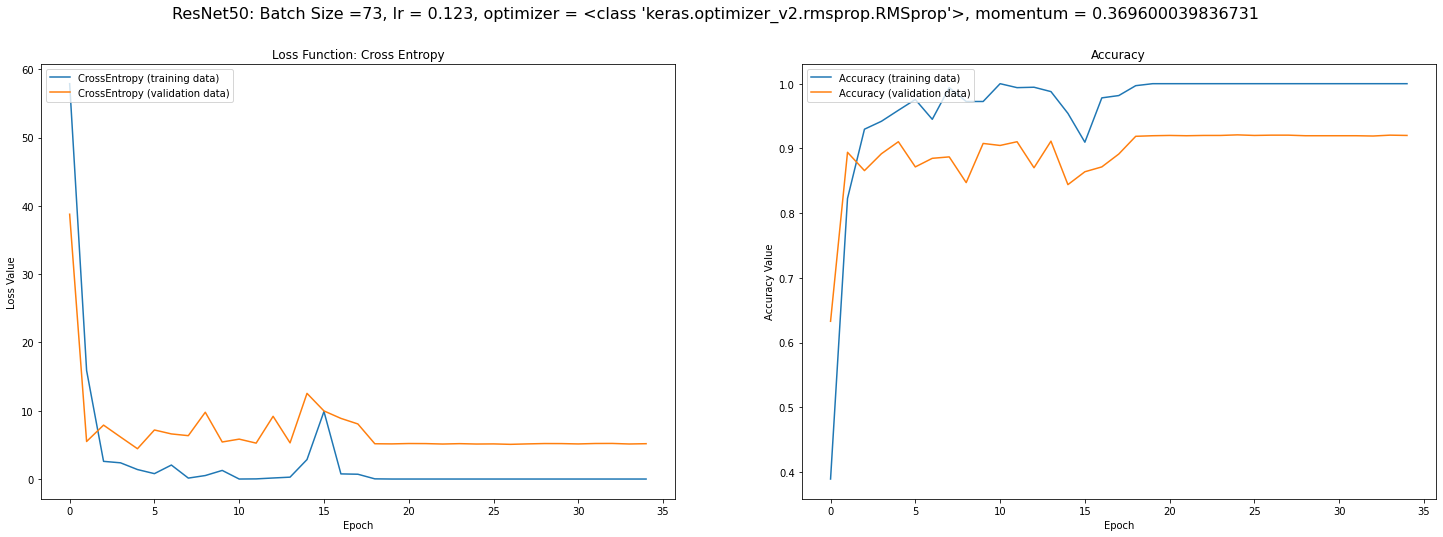

Loading: /content/drive/MyDrive/MIT_small_train_1/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (59, 224, 224, 3)
------------------------------------------------------------------------------------------
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Epoch 1/50
6/6 [==============================] - 32s 6s/step - loss: 14.6900 - accuracy: 0.2874 - val_loss: 10.0927 - val_accuracy: 0.7721
Epoch 2/50
6/6 [==============================] - 29s 5s/step - loss: 4.0898 - accuracy: 0.8729 - val_loss: 1.6037 - val_accuracy: 0.8626
Epoch 3/50
6/6 [==============================] - 29s 5s/step - loss: 0.7345 - accuracy: 0.9443 - val_loss: 1.5367 - val_accuracy: 0.8814
Epoch 4/50
6/6 [==============================] - 29s 5s/step - loss: 0.4015 - accuracy: 0.9413 - val_loss: 0.9641 - val_accuracy: 0.9179
Epoch 5/50
6/6 [==============================] - 23s 4s/step - loss: 0.2948 - accuracy: 0.9677 - val_loss: 0.9760 -

<Figure size 432x288 with 0 Axes>

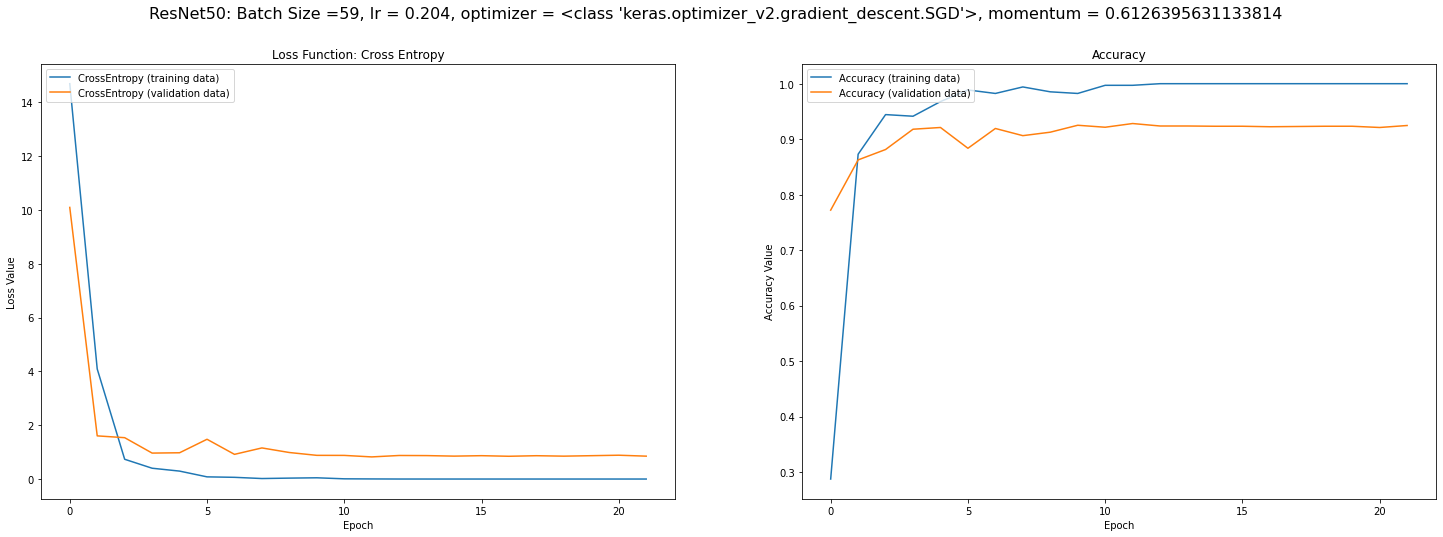

<Figure size 432x288 with 0 Axes>

In [ ]:
from random import random, randint

batch_sizes = [randint(10 ,100) for i in range(7)] 
print('Batch sizes that will be used: ', batch_sizes)

optimizers = [tf.keras.optimizers.SGD, tf.keras.optimizers.RMSprop , tf.keras.optimizers.Adam ,tf.keras.optimizers.Adadelta ,
              tf.keras.optimizers.Adagrad , tf.keras.optimizers.Adamax , tf.keras.optimizers.Nadam] 


for BATCH_SIZE in batch_sizes:
  train_loader_1, test_loader_1 = get_dataset(DATA_DIR.format(1),BATCH_SIZE)
  #After loading the dataset we have to compile the dataset with the desired parameters
  #we will get one random value for the learning rate, the optimizer and the momentum used in the optimizer 
  opti = np.random.randint( 6,  size = 1)
  
  lr_random = random()#number between 0-1
  lr = 0.0001 + (lr_random * (0.3 - 0.0001))#rescaling the number to our range of interest between 0.0001 and 0.3
  mom_random = random()#number between 0-1
  moment =  (lr_random * (0.9))
  if opti<2:
    optimizer = optimizers[opti[0]](learning_rate = lr , momentum = moment)
  else: 
    optimizer = optimizers[opti[0]](learning_rate = lr )
    moment = 'Not used'

  model = buil_custom_resnet50(opti = optimizer,summary=False)
  # We will train all the models with 50 epochs and set an early stop if the validation accuracy doesn't get better after 10 epochs 
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

  history_1 = model.fit(train_loader_1,steps_per_epoch= int(400 // BATCH_SIZE), epochs = 50, validation_data=test_loader_1, validation_steps= int(validation_samples // BATCH_SIZE),  callbacks=[early_stop])
  plot_loss_accuracy(history_1, 'ResNet50: Batch Size ={}, lr = {}, optimizer = {}, momentum = {}'.format(BATCH_SIZE, round(lr,3),optimizers[opti[0]], moment ))


After the first one we will perform a second random search to get better result with the range of values adjusted and only ussin SGD. 


Batch sizes that will be used:  [43, 42, 48, 63, 62]
Loading: /content/drive/MyDrive/MIT_small_train_1/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (43, 224, 224, 3)
------------------------------------------------------------------------------------------
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Epoch 1/50
9/9 [==============================] - 418s 51s/step - loss: 3.8539 - accuracy: 0.3669 - val_loss: 1.3000 - val_accuracy: 0.7863
Epoch 2/50
9/9 [==============================] - 26s 3s/step - loss: 0.4615 - accuracy: 0.9048 - val_loss: 0.2866 - val_accuracy: 0.9153
Epoch 3/50
9/9 [==============================] - 26s 3s/step - loss: 0.1639 - accuracy: 0.9412 - val_loss: 0.2897 - val_accuracy: 0.9096
Epoch 4/50
9/9 [==============================] - 29s 4s/step - loss: 0.1566 - accuracy: 0.9524 - val_loss: 0.2468 - val_accuracy: 0.9263
Epoch 5/50
9/9 [==============================] - 30s 4s/step -

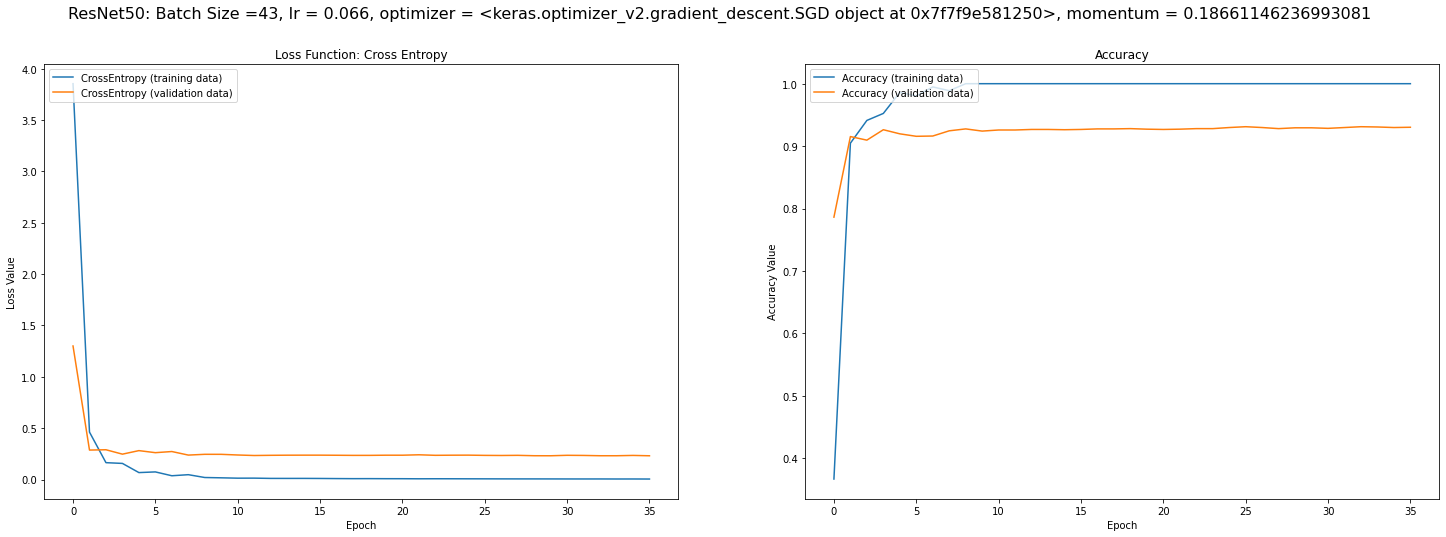

Loading: /content/drive/MyDrive/MIT_small_train_1/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (42, 224, 224, 3)
------------------------------------------------------------------------------------------
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Epoch 1/50
9/9 [==============================] - 28s 3s/step - loss: 2.8972 - accuracy: 0.5370 - val_loss: 0.4298 - val_accuracy: 0.8814
Epoch 2/50
9/9 [==============================] - 26s 3s/step - loss: 0.2992 - accuracy: 0.9312 - val_loss: 0.3371 - val_accuracy: 0.9070
Epoch 3/50
9/9 [==============================] - 30s 4s/step - loss: 0.1446 - accuracy: 0.9581 - val_loss: 0.2769 - val_accuracy: 0.9237
Epoch 4/50
9/9 [==============================] - 29s 4s/step - loss: 0.0623 - accuracy: 0.9777 - val_loss: 0.2991 - val_accuracy: 0.9114
Epoch 5/50
9/9 [==============================] - 30s 4s/step - loss: 0.0350 - accuracy: 0.9888 - val_loss: 0.3003 - v

<Figure size 432x288 with 0 Axes>

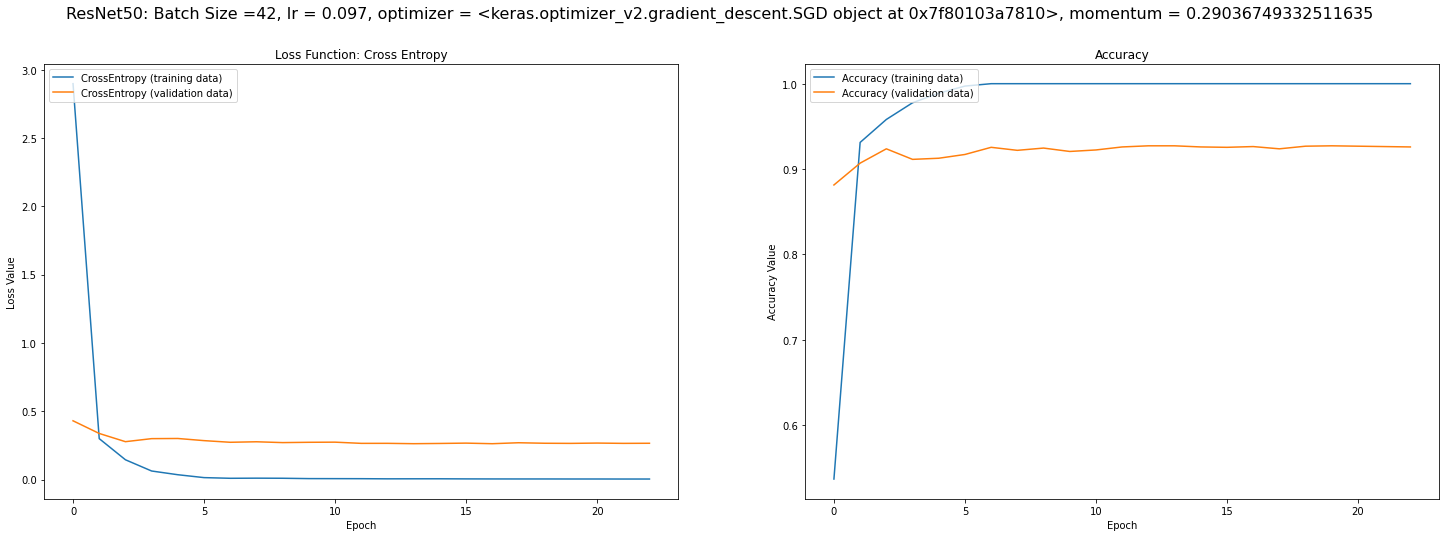

Loading: /content/drive/MyDrive/MIT_small_train_1/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (48, 224, 224, 3)
------------------------------------------------------------------------------------------
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Epoch 1/50
8/8 [==============================] - 31s 4s/step - loss: 3.6193 - accuracy: 0.4886 - val_loss: 0.4463 - val_accuracy: 0.8741
Epoch 2/50
8/8 [==============================] - 25s 3s/step - loss: 0.5406 - accuracy: 0.8920 - val_loss: 0.3189 - val_accuracy: 0.9087
Epoch 3/50
8/8 [==============================] - 25s 3s/step - loss: 0.1615 - accuracy: 0.9545 - val_loss: 0.3226 - val_accuracy: 0.9038
Epoch 4/50
8/8 [==============================] - 30s 4s/step - loss: 0.1109 - accuracy: 0.9661 - val_loss: 0.3015 - val_accuracy: 0.9180
Epoch 5/50
8/8 [==============================] - 29s 4s/step - loss: 0.0796 - accuracy: 0.9688 - val_loss: 0.2747 - v

<Figure size 432x288 with 0 Axes>

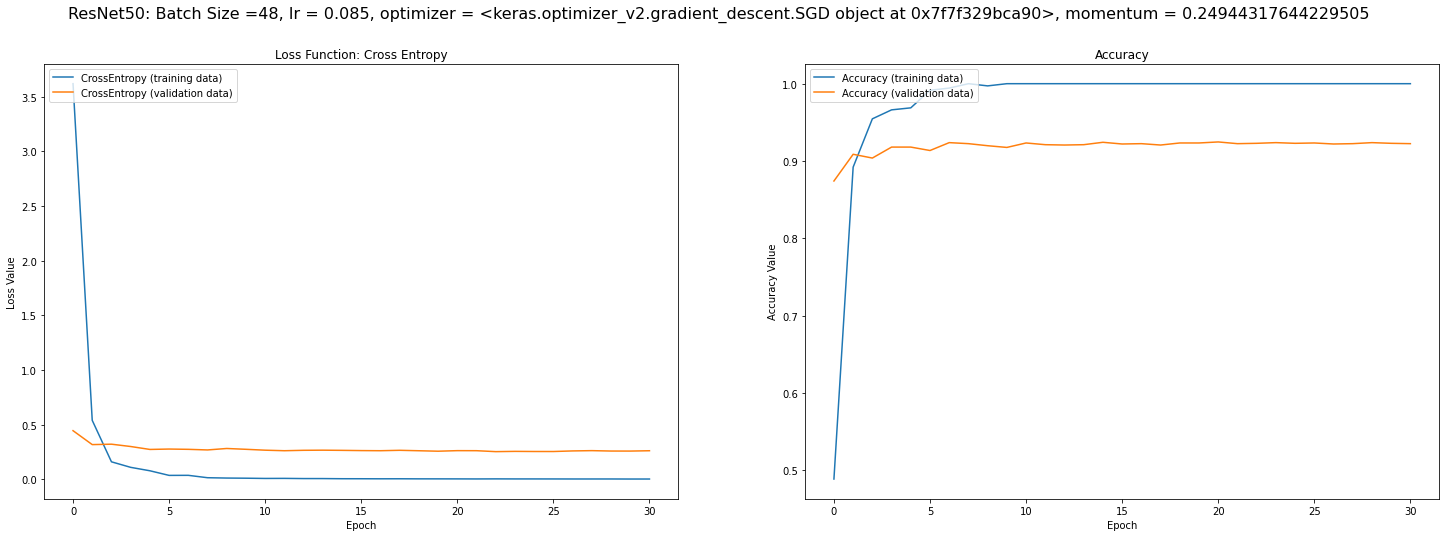

Loading: /content/drive/MyDrive/MIT_small_train_1/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (63, 224, 224, 3)
------------------------------------------------------------------------------------------
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Epoch 1/50
6/6 [==============================] - 27s 5s/step - loss: 1.7985 - accuracy: 0.5460 - val_loss: 0.3985 - val_accuracy: 0.8686
Epoch 2/50
6/6 [==============================] - 29s 5s/step - loss: 0.3452 - accuracy: 0.8991 - val_loss: 0.2576 - val_accuracy: 0.9131
Epoch 3/50
6/6 [==============================] - 29s 5s/step - loss: 0.1462 - accuracy: 0.9525 - val_loss: 0.2344 - val_accuracy: 0.9175
Epoch 4/50
6/6 [==============================] - 29s 5s/step - loss: 0.1022 - accuracy: 0.9644 - val_loss: 0.2411 - val_accuracy: 0.9131
Epoch 5/50
6/6 [==============================] - 29s 5s/step - loss: 0.0581 - accuracy: 0.9852 - val_loss: 0.2406 - v

<Figure size 432x288 with 0 Axes>

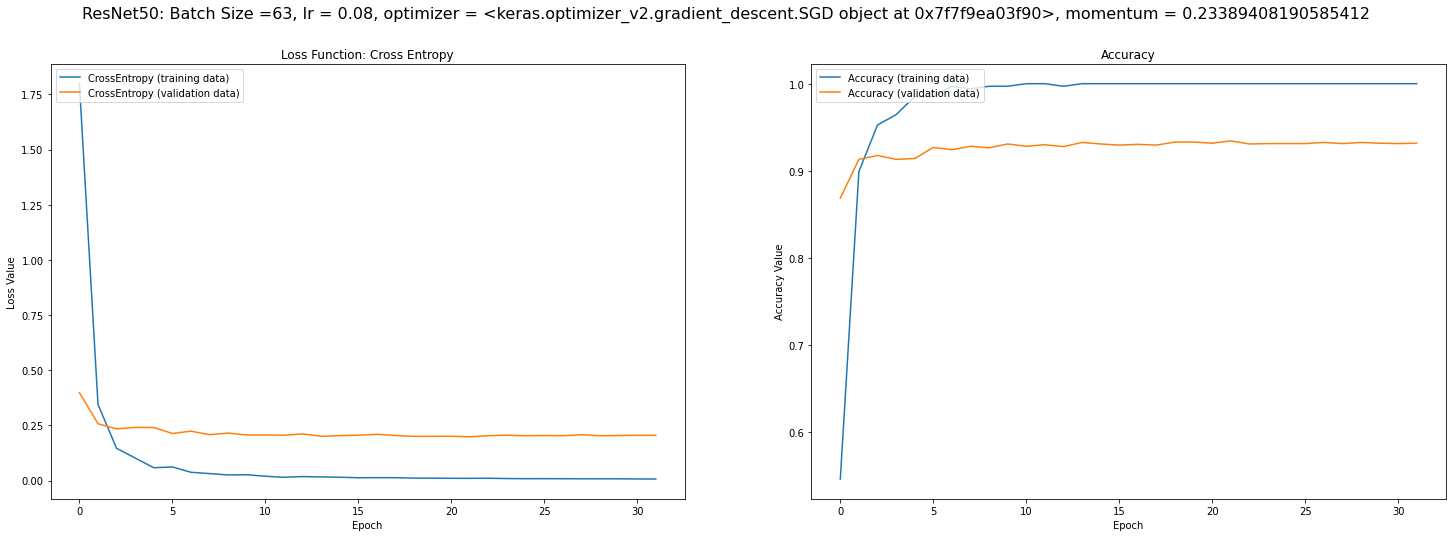

Loading: /content/drive/MyDrive/MIT_small_train_1/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (62, 224, 224, 3)
------------------------------------------------------------------------------------------
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Epoch 1/50
6/6 [==============================] - 32s 6s/step - loss: 1.4637 - accuracy: 0.5680 - val_loss: 0.3972 - val_accuracy: 0.8701
Epoch 2/50
6/6 [==============================] - 24s 4s/step - loss: 0.3537 - accuracy: 0.8905 - val_loss: 0.3318 - val_accuracy: 0.8889
Epoch 3/50
6/6 [==============================] - 24s 4s/step - loss: 0.2182 - accuracy: 0.9408 - val_loss: 0.2553 - val_accuracy: 0.9220
Epoch 4/50
6/6 [==============================] - 25s 5s/step - loss: 0.1606 - accuracy: 0.9556 - val_loss: 0.2662 - val_accuracy: 0.9068
Epoch 5/50
6/6 [==============================] - 29s 5s/step - loss: 0.1390 - accuracy: 0.9793 - val_loss: 0.2605 - v

<Figure size 432x288 with 0 Axes>

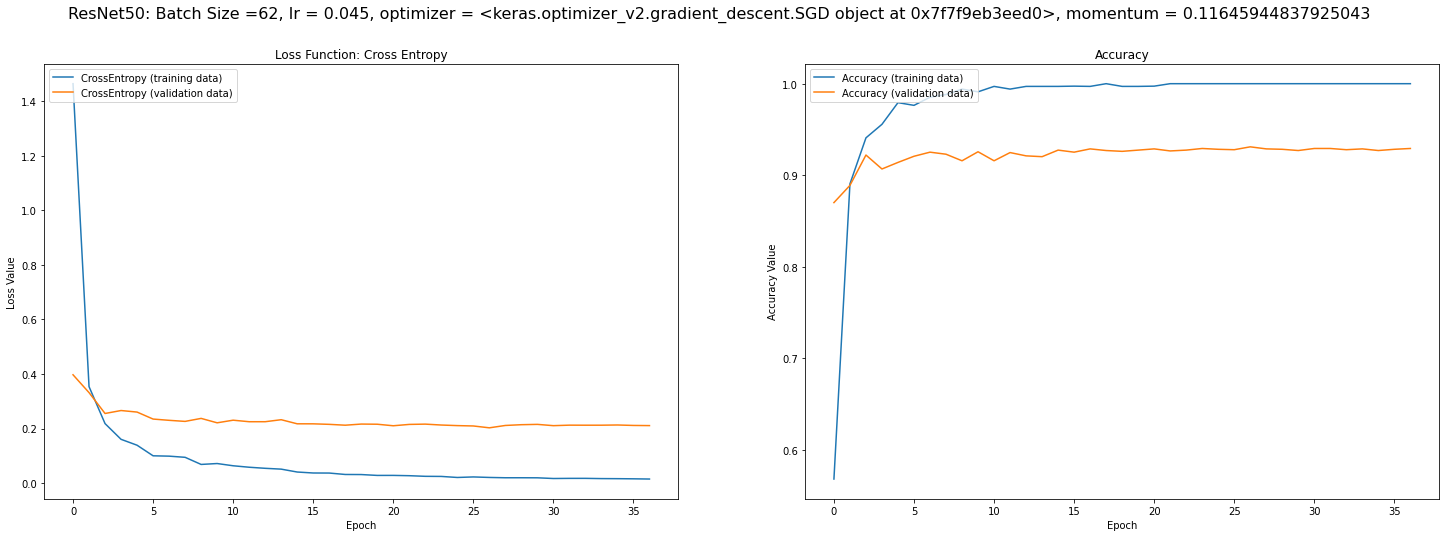

<Figure size 432x288 with 0 Axes>

In [ ]:
from random import random, randint

batch_sizes = [randint(30 ,70) for i in range(5)] 
print('Batch sizes that will be used: ', batch_sizes)


for BATCH_SIZE in batch_sizes:
  train_loader_1, test_loader_1 = get_dataset(DATA_DIR.format(1),BATCH_SIZE)
  #After loading the dataset we have to compile the dataset with the desired parameters
  #we will get one random value for the learning rate, the optimizer and the momentum used in the optimizer 
  
  
  lr_random = random()#number between 0-1
  lr = 0.04 + (lr_random * (0.1 - 0.04))#rescaling the number to our range of interest between 0.0001 and 0.3
  mom_random = random()#number between 0-1
  moment =  0.1 + (lr_random * (0.3 - 0.1))
  
  optimizer = tf.keras.optimizers.SGD(learning_rate = lr , momentum = moment)
 
  model = buil_custom_resnet50(opti = optimizer,summary=False)
  # We will train all the models with 50 epochs and set an early stop if the validation accuracy doesn't get better after 10 epochs 
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

  history_1 = model.fit(train_loader_1,steps_per_epoch= int(400 // BATCH_SIZE), epochs = 50, validation_data=test_loader_1, validation_steps= int(validation_samples // BATCH_SIZE),  callbacks=[early_stop])
  plot_loss_accuracy(history_1, 'ResNet50: Batch Size ={}, lr = {}, optimizer = {}, momentum = {}'.format(BATCH_SIZE, round(lr,3), optimizer , moment ))

After the previous test we found the hyperparaeters to perform a satisfying classification with the given dataset. Now we will try to enhance it more with data augmentation. 

**Data augmentation** 

Now we will introduce different transformations to our datset in order to enlarge the number of cases that the neural network is being trained with. After that it will be tested with the test dataset without applying the transformations.  

In [ ]:
#Loading training and validation with data augmentation
BATCH_SIZE = 62

datagen_train_valdidation = ImageDataGenerator(featurewise_center=False,
              samplewise_center=False,
              featurewise_std_normalization=False,
              samplewise_std_normalization=False,
              preprocessing_function=preprocess_input_manual,
              rotation_range=0.,
              width_shift_range=15,
              height_shift_range=15,
              shear_range=0.,
              zoom_range=0.2,
              channel_shift_range=0.,
              fill_mode='nearest',
              cval=0.,
              horizontal_flip=True,
              vertical_flip=False,
              rescale=None, 
              validation_split=0.2)

train_loader = datagen_train_valdidation.flow_from_directory(
            path+'/train',  
            target_size=(IMG_SIZE, IMG_SIZE), 
            batch_size=BATCH_SIZE,
            classes = CLASSES,
            class_mode='categorical', 
            subset='training') 

validation_loader = datagen_train_valdidation.flow_from_directory(
          path+'/train',  
          target_size=(IMG_SIZE, IMG_SIZE), 
          batch_size=BATCH_SIZE,
          classes = CLASSES,
          class_mode='categorical', 
          subset='validation') 

#loading test data without data augmentation
datagen_test = ImageDataGenerator(featurewise_center=False,
          samplewise_center=False,
          featurewise_std_normalization=False,
          samplewise_std_normalization=False,
          preprocessing_function=preprocess_input_manual,
          rotation_range=0.,
          width_shift_range=0.,
          height_shift_range=0.,
          shear_range=0.,
          zoom_range=0.,
          channel_shift_range=0.,
          fill_mode='nearest',
          cval=0.,
          horizontal_flip=False,
          vertical_flip=False,
          rescale=None)

test_loader = datagen_test.flow_from_directory(
        path+'/test',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        classes = CLASSES,
        class_mode='categorical')

In [ ]:
# Build the model with the best found hyperparameters and we will also introduce learninf rate deacy to see if the accuracy can get better with it 
lr = 0.045
moment = 0.11

optimizer = tf.keras.optimizers.SGD(learning_rate = lr , momentum = moment)

model = buil_custom_resnet50(opti = optimizer,summary=False)
# We will train all the models with 50 epochs and set an early stop if the validation accuracy doesn't get better after 15 epochs
#and also reduce the learning rate after 5 epochs with no improvement by a factor 0.1
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)
reduce_lr =   tf.keras.callbacks.ReduceLROnPlateau(
      monitor="val_accuracy",
      factor=0.1,
      patience=5,
      verbose=0,
      mode="auto",
      min_delta=0,
      cooldown=0)

history_1 = model.fit(train_loader_1,steps_per_epoch= int(400 // BATCH_SIZE), epochs = 100, validation_data=test_loader_1, validation_steps= int(validation_samples // BATCH_SIZE),  callbacks=[early_stop, reduce_lr])
plot_loss_accuracy(history_1, 'ResNet50: Batch Size ={}, lr = {}, optimizer = {}, momentum = {}'.format(BATCH_SIZE, round(lr,3), optimizer , moment ))